In [1]:
import pyspark
from pyspark.sql import SparkSession
from pathlib import Path

In [2]:
# The SparkSession API provides a single point of entry to interact with Spark functionality,
# including Spark SQL, DataFrames, Datasets, and other Spark features.
spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/22 15:41:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# load CSV into a Spark DataFrame
file_name = 'online_retail.csv'
current_directory = Path.cwd()
file_directory = current_directory / file_name
df = spark.read.csv(str(file_directory), header=True,escape="\"")

In [4]:
# show the top 5 rows
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

In [5]:
# applies the aggration function of count and returns its value
df.count()

541909

In [6]:
# applies the aggration function of distinct and count and returns its value
df.select('CustomerID').distinct().count()

4373

In [7]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [8]:
# show the which countries made the most purchases, order resultsin descending order
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [9]:
# show the most recent purchase
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2012-12-10 16:21:00|
+-------------------+



In [10]:
# Overall, this code snippet is used to convert a string column to a timestamp format
# and calculate the time difference between two columns in a PySpark DataFrame.

# creates a new column called "from_date" in the PySpark DataFrame "df"
# and sets all values in this column to the string "12/1/10 08:26".
df = df.withColumn("from_date", lit("12/1/10 08:26"))
# converts the "from_date" column from a string to a timestamp format using the "to_timestamp" function.
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))
# creates a new DataFrame called "df2" by applying two transformations to the original DataFrame "df"
df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [11]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [12]:
# show the top 5 rows
df2.show(5,0)

+-------+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |
+-------+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|540    |536369   |21756    |BATH BUILDING BLOCK WORD          |3       |12/1/10 8:35|5.95     |13047     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|
|2040   |536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS    |80      |12/1/10 9:00|2.55     |13748     |United Kingdom|2012-01-10 09:00:00|2012-01-10 08:26:00|
|3960   |536375   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |12/1/10 9:32|2.55     |17850     |United Kingdom|2012-01-10 09:32:00|2012-01-10 08:26:00|
|3960   |536375   |710

In [13]:
# view all the variablespresent in a PySpark dataframe is to use its printSchema() function.
# This is the equivalent of the info() function in Pandas
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [14]:
# Let’s now calculate the value of frequency - how often a customer bought something on the platform. 
# To do this, we just need to group by each customer ID and count the number of items they purchased
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))


In [15]:
# show top 5 rows from the frequency DataFrame
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|16250     |14       |
|15574     |121      |
|15271     |24       |
|15555     |37       |
|17757     |49       |
+----------+---------+
only showing top 5 rows



In [16]:
# inner join df2 DataFrame with df_freq DataFrame on key 'CustomerID'
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [17]:
# print the schema to show we joined the DataFrames successfully
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [18]:
# show the top 5 rows of df3 DataFrame
df3.show(5,0)

+----------+-------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|recency|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|Country       |date               |from_date          |frequency|
+----------+-------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+---------+
|13047     |540    |536369   |21756    |BATH BUILDING BLOCK WORD          |3       |12/1/10 8:35|5.95     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|1        |
|13748     |2040   |536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS    |80      |12/1/10 9:00|2.55     |United Kingdom|2012-01-10 09:00:00|2012-01-10 08:26:00|1        |
|17850     |3960   |536375   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |12/1/10 9:32|2.55     |United Kingdom|2012-01-10 09

In [19]:
# Calculate the monetary value spent by each customer
# we create a new column in our m_val DataFrame as the output of multiplying Quantity and UnitePrice from df3 DataFrame
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))


In [20]:
# show the top 5 rows of df3 DataFrame
m_val.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)
 |-- TotalAmount: double (nullable = true)



In [21]:
# show the newly created TotalAmount column based on quantity and unit price
m_val.show(5,0)

+----------+-------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+---------+------------------+
|CustomerID|recency|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|Country       |date               |from_date          |frequency|TotalAmount       |
+----------+-------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+---------+------------------+
|13047     |540    |536369   |21756    |BATH BUILDING BLOCK WORD          |3       |12/1/10 8:35|5.95     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|1        |17.85             |
|13748     |2040   |536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS    |80      |12/1/10 9:00|2.55     |United Kingdom|2012-01-10 09:00:00|2012-01-10 08:26:00|1        |204.0             |
|17850     |3960   |536375   |85123A   |

In [22]:
# To find the total amount spent by each customer overall, we just need to group by the CustomerID column and sum the total amount spent
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))


In [23]:
# show the schema of m_val DataFrame
m_val.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- monetary_value: double (nullable = true)



In [24]:
# show the top 5 rows of m_val DataFrame
m_val.show(5,0)

24/01/22 15:41:57 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+----------+-----------------+
|CustomerID|monetary_value   |
+----------+-----------------+
|16250     |226.14           |
|15574     |375.65           |
|15271     |111.75           |
|15555     |620.3499999999998|
|17757     |385.25           |
+----------+-----------------+
only showing top 5 rows



In [25]:
# merge this DataFrame with all the other variables
finaldf = m_val.join(df3,on='CustomerID',how='inner')


In [26]:
# show the schema of finaldf DataFrame
finaldf.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- monetary_value: double (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [27]:
# show the schema of finaldf DataFrame
finaldf.show(5,0)

+----------+--------------+-------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|monetary_value|recency|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|Country       |date               |from_date          |frequency|
+----------+--------------+-------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+---------+
|13047     |17.85         |540    |536369   |21756    |BATH BUILDING BLOCK WORD          |3       |12/1/10 8:35|5.95     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|1        |
|13748     |204.0         |2040   |536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS    |80      |12/1/10 9:00|2.55     |United Kingdom|2012-01-10 09:00:00|2012-01-10 08:26:00|1        |
|17850     |533.22        |3960   |536375   |85123A   |WHITE

In [28]:
# We now have all the necessary variables needed for our machhine learning model
# select only the required columns and drop duplicate rows from the dataframe
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [29]:
# show the schema of finaldf DataFrame
finaldf.printSchema()

root
 |-- recency: long (nullable = true)
 |-- frequency: long (nullable = false)
 |-- monetary_value: double (nullable = true)
 |-- CustomerID: string (nullable = true)



In [30]:
# show the schema of finaldf DataFrame
finaldf.show(5,0)

+--------+---------+-----------------+----------+
|recency |frequency|monetary_value   |CustomerID|
+--------+---------+-----------------+----------+
|5580    |14       |226.14           |16250     |
|2704800 |121      |375.65           |15574     |
|21097260|24       |111.75           |15271     |
|21108420|37       |620.3499999999998|15555     |
|23699400|49       |385.25           |17757     |
+--------+---------+-----------------+----------+
only showing top 5 rows



In [31]:
# Before building the customer segmentation model, let’s standardize the dataframe
# to ensure that all the variables are around the same scale

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [32]:
# this is a standardized feature vector
data_scale_output.select('standardized').show(2,truncate=False)

+-------------------------------------------------------------+
|standardized                                                 |
+-------------------------------------------------------------+
|[1.827806692256554E-7,0.4589020319425585,0.07645669520731262]|
|[8.859948998594134E-5,3.9662247046463985,0.12700520719300867]|
+-------------------------------------------------------------+
only showing top 2 rows



We are now done with analysis, feature engineering, and model preparation. The next step involves 

In [33]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

24/01/22 15:55:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/22 15:55:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


With the codes above, we have successfully built and evaluated a K-Means clustering model with 2 to 10 clusters. The results have been placed in an array, and can now be visualized in a line chart:

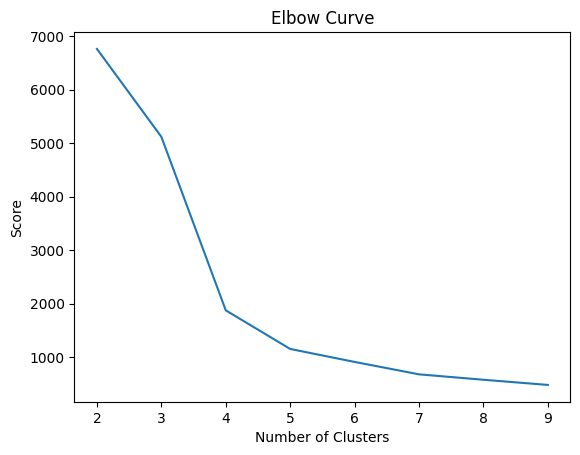

In [35]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

There seems to be an elebow (an inflection point of diminishing returns) at four clusters. Thus, we will procede to only use four clusters for our K-means algorithm. 

In [36]:
# creating the modle to assign clusters to each custumer in the dataset
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [37]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+--------+---------+-----------------+----------+-----------------------------------+--------------------------------------------------------------+----------+
|recency |frequency|monetary_value   |CustomerID|features                           |standardized                                                  |prediction|
+--------+---------+-----------------+----------+-----------------------------------+--------------------------------------------------------------+----------+
|5580    |14       |226.14           |16250     |[5580.0,14.0,226.14]               |[1.827806692256554E-7,0.4589020319425585,0.07645669520731262] |0         |
|2704800 |121      |375.65           |15574     |[2704800.0,121.0,375.65]           |[8.859948998594134E-5,3.9662247046463985,0.12700520719300867] |3         |
|21097260|24       |111.75           |15271     |[2.109726E7,24.0,111.75]           |[6.910701257397224E-4,0.7866891976158146,0.037782062834603274]|0         |
|21108420|37       |620.3499999999998|15

The prediction column shows us where the algorithm assigned the customer to a cluster.